In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from tqdm import tqdm
import time_lag_optimizers as tlo
import importlib
import helpers
from sklearn.metrics import mean_squared_error


In [65]:
plt.rcParams["figure.figsize"] = (10,5)


In [66]:
dataset= pd.read_csv("dataset.csv")
# drop the iron concetration column, as we are not allowed to use it
dataset.drop("% Iron Concentrate", axis=1, inplace=True)

dataset["date"] = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')

for col in dataset.columns[1:]:
    dataset[col] = dataset[col].apply(lambda x: x.replace(",", "."))
    dataset[col] = dataset[col].astype(float)

dataset


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,2017-03-10 01:00:00,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,1.31
1,2017-03-10 01:00:00,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,...,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,1.31
2,2017-03-10 01:00:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,...,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,1.31
3,2017-03-10 01:00:00,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,...,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,1.31
4,2017-03-10 01:00:00,55.20,16.98,3033.69,558.167,400.254,10.06970,1.74000,250.203,252.136,...,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,1.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737448,2017-09-09 23:00:00,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,...,346.794,313.695,392.160,430.702,872.008,418.725,497.548,446.357,416.892,1.71
737449,2017-09-09 23:00:00,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,...,330.023,236.700,401.505,404.616,864.409,418.377,506.398,372.995,426.337,1.71
737450,2017-09-09 23:00:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,...,329.590,225.879,408.899,399.316,867.598,419.531,503.414,336.035,433.130,1.71
737451,2017-09-09 23:00:00,49.75,23.20,1164.12,491.548,384.976,9.61686,1.65324,302.550,301.959,...,351.453,308.115,405.107,466.832,876.591,407.299,502.301,340.844,433.966,1.71


In [67]:
# check for missing values
print("Are there missing values?")
dataset.isna().values.any()


Are there missing values?


False

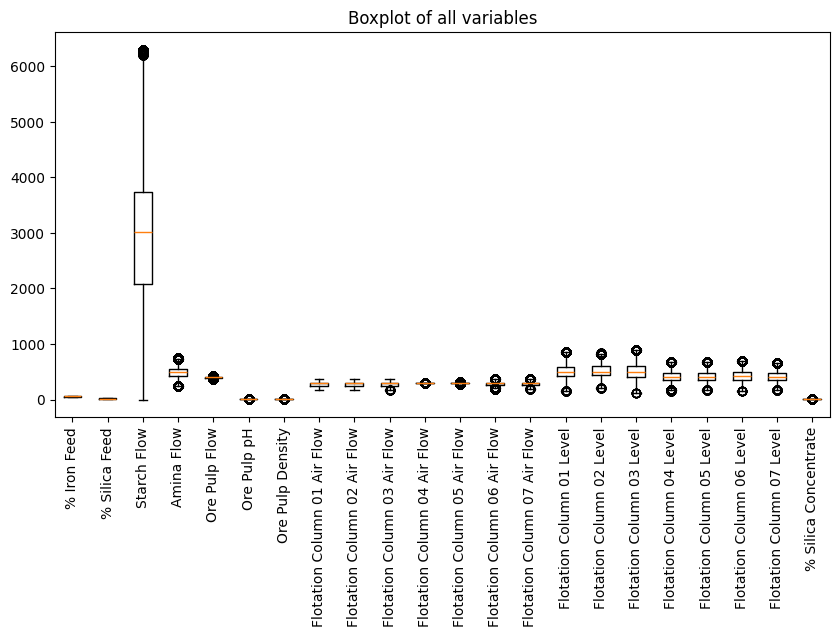

In [68]:
dataset_wo_date = dataset.drop("date", axis=1)

plt.title("Boxplot of all variables")
plt.boxplot(dataset_wo_date)
plt.xticks(range(1, len(dataset_wo_date.columns) + 1), dataset_wo_date.columns.to_list(), rotation=90)
plt.show()


# Resolving timestamp problems

In [69]:
EXPECTED_SAMPLE_COUNT = 180

# determine which timestamps are incomplete
def determine_incomplete_dates(df):
    last_date = df.date.iloc[0]
    current_count = 1
    invalid_counts = []
    for date in df.date.iloc[1:]:
        if last_date == date:
            current_count += 1
        else:
            if current_count != EXPECTED_SAMPLE_COUNT:
                invalid_counts.append((last_date, current_count))
            last_date = date
            current_count = 1

    if invalid_counts:
        print("Timestamps with missing values:")
        for timestamp, count in invalid_counts:
            print(f"{timestamp}: {count} samples")
    else:
        print("All dates have correct number of samples")

determine_incomplete_dates(dataset)


Timestamps with missing values:
2017-03-10 01:00:00: 174 samples
2017-04-10 00:00:00: 179 samples


In [70]:
# remove first 174 rows, as the measurement is incomplete
dataset.drop(index=dataset.index[:174], axis=0, inplace=True)

# duplicate the last row of the date with 179 measurements
line = dataset.loc[dataset.date == "2017-04-10 00:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])
dataset = pd.concat([dataset.iloc[:iloc], line, dataset.iloc[iloc:]]).reset_index(drop=True)


In [71]:
determine_incomplete_dates(dataset)


All dates have correct number of samples


Timedelta 3600.0: 4094x
Timedelta 1148400.0: 1x


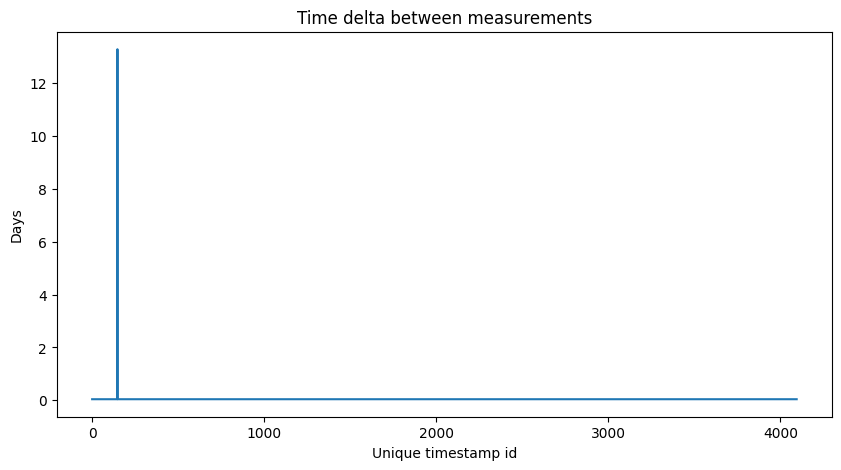

In [72]:
# check if timedelta is same throughout the dataset
def check_timedeltas(df):
    udates = df.date.unique()
    last = udates[0]
    timedeltas = []
    for date in udates[1:]:
        timedeltas.append((date-last) / np.timedelta64(1, 's'))
        last = date

    timedeltas = np.array(timedeltas)
    unique, counts = np.unique(timedeltas, return_counts=True)
    for value, count in zip(unique, counts):
        print(f"Timedelta {value}: {count}x")
    return timedeltas

timedeltas = check_timedeltas(dataset)
plt.title("Time delta between measurements")
plt.plot(timedeltas/60/60/24)
plt.xlabel("Unique timestamp id")
plt.ylabel("Days")
plt.show()


In [73]:
# find the gap
udates = dataset.date.unique()
last = udates[0]
for date in udates[1:]:
    if (date-last) / np.timedelta64(1, 's') != 3600.0:
        print(pd.to_datetime(last).strftime('%Y-%m-%d %H:%M:%S'))
    last = date


2017-03-16 05:00:00


In [74]:
line = dataset.loc[dataset.date == "2017-03-16 05:00:00"].tail(1)
iloc = dataset.index.get_loc(line.index.values[0])

dataset_small = dataset.iloc[:iloc+1]
dataset_big = dataset.iloc[iloc+1:]


In [75]:
_ = check_timedeltas(dataset_small)


Timedelta 3600.0: 147x


In [76]:
_ = check_timedeltas(dataset_big)


Timedelta 3600.0: 3947x


# Resampling

In [77]:
# subsample - replace every 180 values with their means

new_df = pd.DataFrame(columns=dataset_big.columns)

for i, date in enumerate(dataset_big.date.unique()):
    new_df.loc[i] = dataset_big[dataset_big.date == date].mean()
    new_df.loc[i, "date"] = date
new_df


,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,2017-03-29 12:00:00,60.18,9.34,1060.859297,379.836203,400.982539,9.527187,1.550374,200.035839,195.5777,...,250.069722,249.992956,753.724247,726.559437,860.557818,477.349197,452.512522,478.219647,470.105547,1.36
1,2017-03-29 13:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.10625,...,250.029056,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,1.43
2,2017-03-29 14:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.6452,200.019311,195.604928,...,249.979356,250.111328,851.951492,776.293654,879.704989,456.147231,453.227,447.708467,453.475667,1.33
3,2017-03-29 15:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,...,249.978589,250.028506,855.91063,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,1.27
4,2017-03-29 16:00:00,59.54,9.56,1367.502858,317.134072,400.836283,9.936163,1.530984,199.878922,196.162864,...,250.061661,250.122067,851.603513,784.446084,884.840698,450.12305,451.774694,451.574422,449.406894,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,2017-09-09 19:00:00,49.75,23.2,3327.047776,497.211189,380.8472,9.176166,1.660871,301.565561,300.169133,...,335.658144,298.736661,397.781583,498.753311,403.858956,398.930467,502.971728,399.468911,400.559511,1.65
3944,2017-09-09 20:00:00,49.75,23.2,4225.800333,508.963856,381.112889,9.387541,1.691996,300.050172,299.967839,...,348.1728,303.599269,399.928567,499.64895,399.208611,399.967122,501.624533,398.905006,400.486233,1.71
3945,2017-09-09 21:00:00,49.75,23.2,2808.214692,517.748822,381.064411,9.771277,1.735647,299.814289,299.801561,...,349.422803,309.875439,399.961433,500.484917,471.827489,399.931033,500.223311,401.899806,400.556333,1.8
3946,2017-09-09 22:00:00,49.75,23.2,3191.497672,492.511228,380.445006,9.782121,1.716644,300.122756,299.679472,...,349.613589,305.254558,399.601383,498.614494,836.277192,400.455389,500.406239,402.703283,401.769072,1.96


In [78]:
dataset_big = new_df


In [79]:
dataset_big.reset_index(drop=True, inplace=True)

dataset_small_wo_date = dataset_small.drop("date", axis=1)
dataset_big_wo_date = dataset_big.drop("date", axis=1)


# Establishing time lag optimality

In [80]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


dataset_big.loc[:,'date'] = pd.to_datetime(dataset_big['date'])

tss = TimeSeriesSplit(n_splits = 2)

dataset_big.set_index('date', inplace=True)
dataset_big.sort_index(inplace=True)
X = dataset_big.iloc[:,:-1]
train_y = dataset_big.iloc[:,-1:]

for train_index, rest in tss.split(X):
    X_calib, X_rest = X.iloc[train_index, :], X.iloc[rest,:]
    y_calib, y_rest = train_y.iloc[train_index], train_y.iloc[rest]

for valid_index, test_index in tss.split(X_rest):
    X_valid, X_test = X_rest.iloc[valid_index, :], X_rest.iloc[test_index,:]
    y_valid, y_test = y_rest.iloc[valid_index], y_rest.iloc[test_index]

#center and scaling
scaler = StandardScaler()
scaler.fit(X_calib)

# Scale the calibration data
scaled_train = scaler.transform(X_calib)
calib_x = pd.DataFrame(scaled_train, columns=X_calib.columns)

#scaling the validation data
scaled_valid = scaler.transform(X_valid)
valid_x = pd.DataFrame(scaled_valid, columns=X_valid.columns)

#scaling the testing data
# X_test = dataset_small_wo_date.iloc[:,:-1]
# y_test = dataset_small_wo_date.iloc[:,-1:]
scaled_test = scaler.transform(X_test)
testing_x = pd.DataFrame(scaled_test, columns=X_test.columns)

#center and scale output column
scalerY = StandardScaler()
scalerY.fit(y_calib)

scaled_y_calib = scalerY.transform(y_calib)
calib_y = pd.DataFrame(scaled_y_calib, columns=y_calib.columns)

scaled_y_valid = scalerY.transform(y_valid)
valid_y = pd.DataFrame(scaled_y_valid, columns=y_valid.columns)

scaled_y_test = scalerY.transform(y_test)
testing_y = pd.DataFrame(scaled_y_test, columns=y_test.columns)




In [81]:
# add lagged target variable to the predictors
calib_x["Lagged Silica Content"] = calib_y.shift(1).copy()
calib_x.drop(calib_x.index[0], inplace=True)
calib_y.drop(0, inplace=True)

valid_x["Lagged Silica Content"] = valid_y.shift(1).copy()
valid_x.drop(valid_x.index[0], inplace=True)
valid_y.drop(0, inplace=True)

testing_x["Lagged Silica Content"] = testing_y.shift(1).copy()
testing_x.drop(testing_x.index[0], inplace=True)
testing_y.drop(0, inplace=True)


In [82]:
# actually determine the optimal time lag

UPPER_LAG_BOUND = 20 # hours
STEP = 1    # hour

calib_x = helpers.reorder_cols(calib_x)
valid_x = helpers.reorder_cols(valid_x)


optimizer = tlo.DynamicOptimizerOneAtATime(STEP, UPPER_LAG_BOUND, "out/test")
res = optimizer.run(calib_x, calib_y, valid_x, valid_y)
res


0.3963289933815027
0.35136419435777194
0.3455560606153013
0.34509161623207857
0.3441453084049387
0.3434064338127124
0.34333748914539935


array([10,  8,  6,  6,  6,  5,  3,  3,  0])

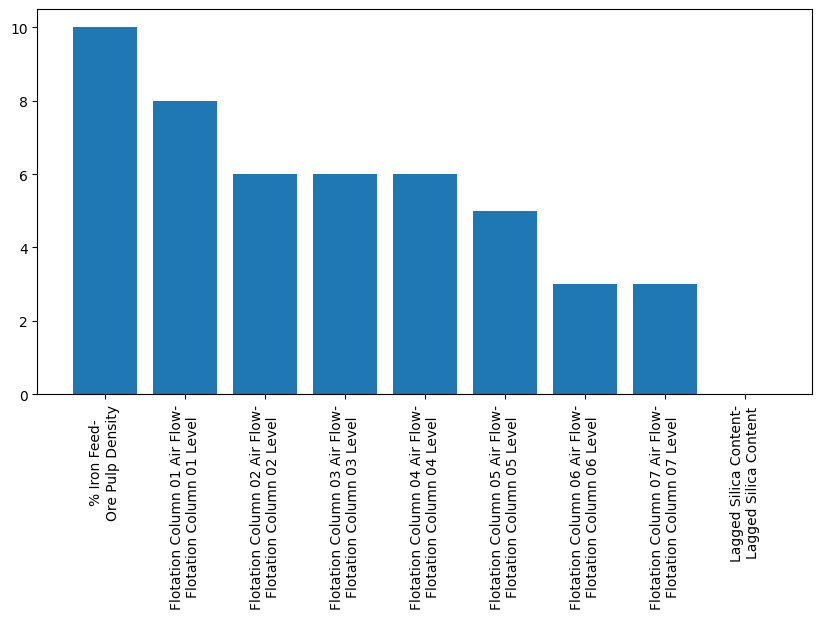

In [83]:
lags = res
all_boundaries = map(lambda x : "-\n".join(x), optimizer.all_boundaries)
plt.bar(range(len(lags)), lags)
plt.xticks(range(len(lags)), all_boundaries, rotation=90)
plt.show()


# Evaluate feature importance

In [84]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score

class ModelEvaluation:
    def __init__(self) -> None:
        self.rsss = []
        self.presss = []
        self.r2s = []
        self.q2s = []
        self.expl_var_Y = []
        self.expl_var_X = []

lagged_calib_x = calib_x.copy()
lagged_calib_y = calib_y.copy()
lagged_valid_x = valid_x.copy()
lagged_valid_y = valid_y.copy()
helpers.applyShifts(lagged_calib_x, lagged_calib_y, lags, optimizer.all_boundaries)
helpers.applyShifts(lagged_valid_x, lagged_valid_y, lags, optimizer.all_boundaries)


max_components = calib_x.shape[1]
tss = np.sum((calib_y - calib_y.mean())**2, axis=0).to_numpy()[0]

model_eval_pls = ModelEvaluation()
for i in range(1, max_components+1):
    model = PLSRegression(n_components=i)
    model.fit(lagged_calib_x, lagged_calib_y)

    pred_train = model.predict(lagged_calib_x).flatten()
    pred_valid = model.predict(lagged_valid_x).flatten()

    rss = np.sum((lagged_calib_y.to_numpy().flatten() - pred_train)**2)
    r2 = 1 - rss/tss
    press = np.sum((lagged_valid_y.to_numpy().flatten() - pred_valid)**2)
    q2 = 1 - press/tss

    model_eval_pls.rsss.append(rss)
    model_eval_pls.presss.append(press)
    model_eval_pls.q2s.append(q2)
    model_eval_pls.r2s.append(r2)
    model_eval_pls.expl_var_X.append(sum((model.x_loadings_ @ model.x_scores_.T).var(axis=1)) / sum(lagged_calib_x.var()))
    model_eval_pls.expl_var_Y.append(explained_variance_score(lagged_calib_y, pred_train))


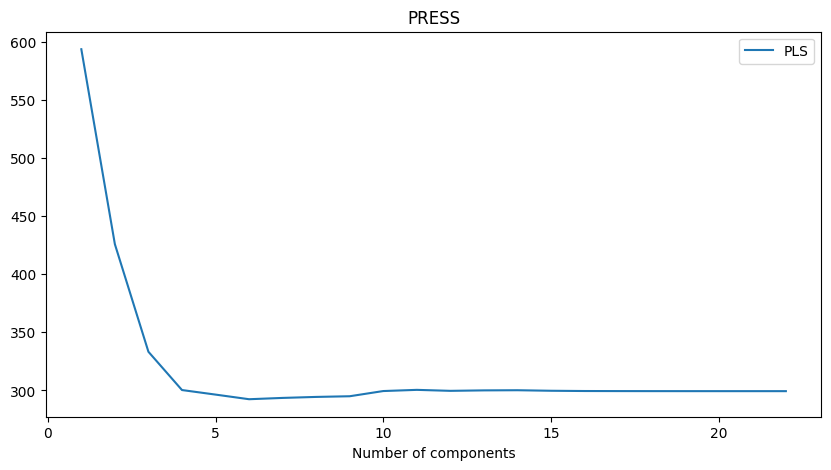

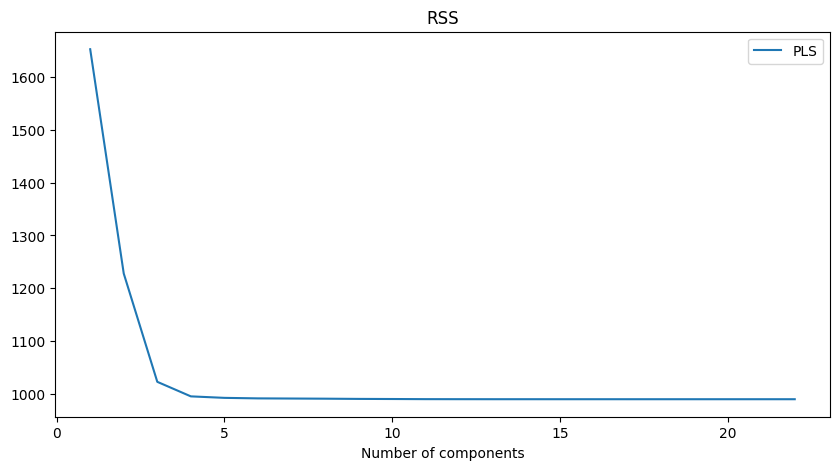

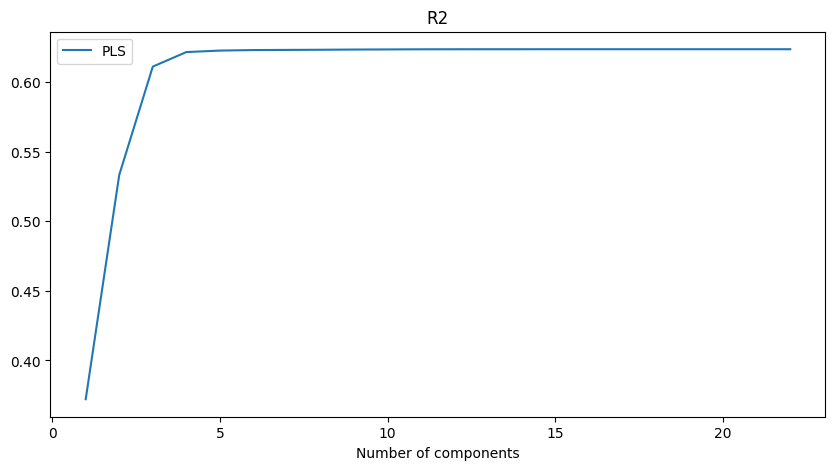

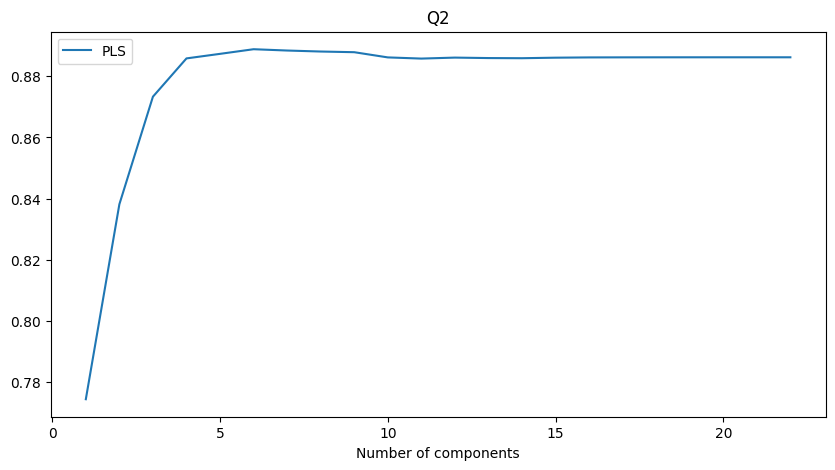

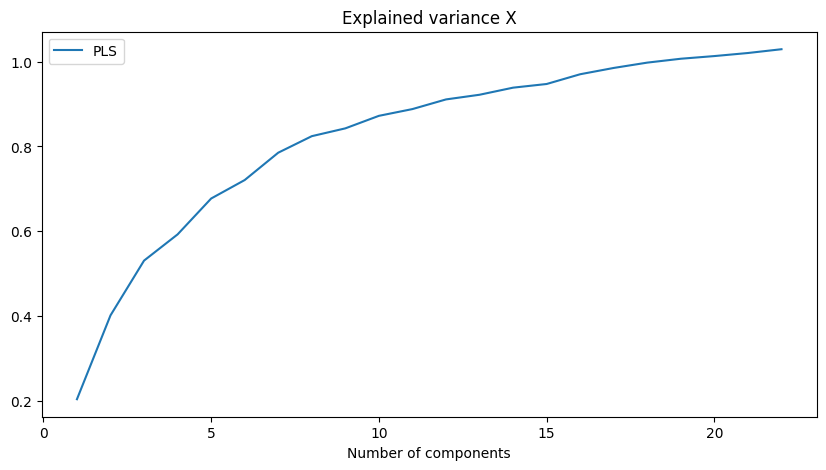

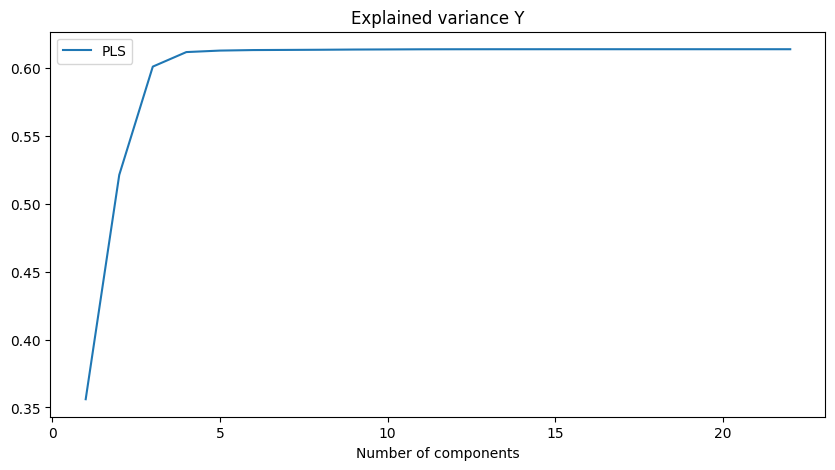

In [85]:
plt.title("PRESS")
plt.plot(range(1, len(model_eval_pls.presss) + 1), model_eval_pls.presss, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()

plt.title("RSS")
plt.plot(range(1, len(model_eval_pls.rsss) + 1), model_eval_pls.rsss, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()

plt.title("R2")
plt.plot(range(1, len(model_eval_pls.r2s) + 1), model_eval_pls.r2s, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()

plt.title("Q2")
plt.plot(range(1, len(model_eval_pls.q2s) + 1), model_eval_pls.q2s, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()

plt.title("Explained variance X")
plt.plot(range(1, len(model_eval_pls.expl_var_X) + 1), model_eval_pls.expl_var_X, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()

plt.title("Explained variance Y")
plt.plot(range(1, len(model_eval_pls.expl_var_Y) + 1), model_eval_pls.expl_var_Y, label="PLS")
plt.xlabel("Number of components")
plt.legend()
plt.show()


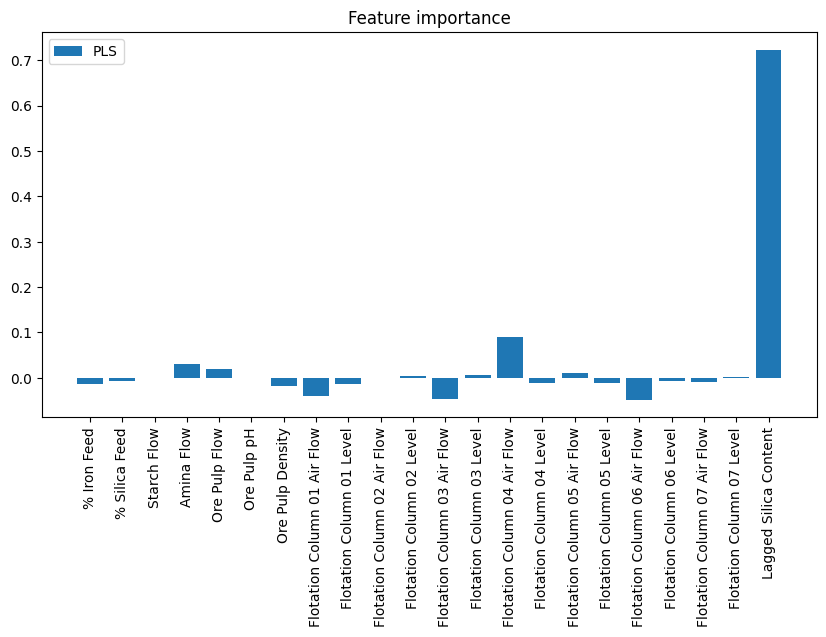

In [86]:
n_comp = 6
model = PLSRegression(n_components=n_comp)
model.fit(lagged_calib_x, lagged_calib_y)
n = len(calib_x.columns)
plt.title("Feature importance")
plt.bar(np.arange(n), model.coef_.flatten(), label="PLS")
plt.xticks(np.arange(n), calib_x.columns, rotation=90)
plt.legend()
plt.show()


In [87]:
# create full model and calculate metrics
n_comp = 6
opt_model = PLSRegression(n_components=n_comp)
opt_model.fit(lagged_calib_x, lagged_calib_y)
y_pred = model.predict(lagged_valid_x).flatten()
full_model_mse = mean_squared_error(lagged_valid_y, y_pred)
full_model_q2 = 1 - full_model_mse / lagged_valid_y.var()

mses = []
q2s = []

# calculate metrics for each component
MAX_COMP = 22
for n in np.arange(1, MAX_COMP):
    # get top indices
    top_idx = np.argsort(np.abs(opt_model.coef_.flatten()))[-n:]
    top_cols = lagged_calib_x.columns[top_idx].values

    # make reduced X sets
    opt_train = lagged_calib_x[top_cols].copy()
    opt_valid = lagged_valid_x[top_cols].copy()

    # predict
    q2 = 0
    mse = 0
    ncompbest = 0
    for i in range(1, n+1):
        model = PLSRegression(n_components=i)
        model.fit(opt_train, lagged_calib_y)

        pred_train = model.predict(opt_train).flatten()
        pred_valid = model.predict(opt_valid).flatten()

        rss = np.sum((lagged_calib_y.to_numpy().flatten() - pred_train)**2)
        r2 = 1 - rss/tss
        press = np.sum((lagged_valid_y.to_numpy().flatten() - pred_valid)**2)
        q2tmp = 1 - press/tss
        if (q2 < q2tmp):
            q2 = q2tmp
            mse = mean_squared_error(lagged_valid_y, pred_valid)
            ncompbest = i

    # n_comp = np.clip(n, 1, 7)
    # model = PLSRegression(n_components=n_comp)
    # model.fit(opt_train, lagged_calib_y)
    # y_pred = model.predict(opt_valid).flatten()

    # # calculate metrics
    # mse = mean_squared_error(lagged_valid_y, y_pred)
    mses.append(mse)
    # q2 = 1 - mse / lagged_valid_y.var()
    q2s.append(q2)
    print(ncompbest)


1
2
3
3
4
5
7
4
4
4
8
5
8
6
6
8
8
8
8
6
6


In [88]:
mean_squared_error(lagged_valid_x["Lagged Silica Content"], lagged_valid_y)


0.3714019358845741

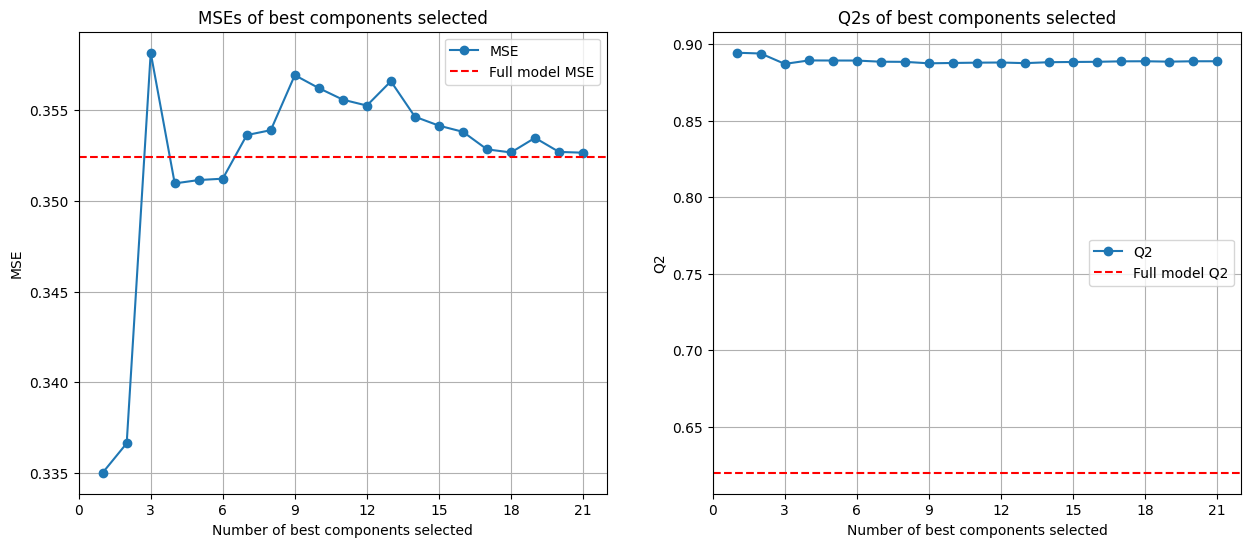

In [89]:
from matplotlib.ticker import MaxNLocator

# plot results
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, MAX_COMP), mses, marker='o', label='MSE')
plt.axhline(full_model_mse, color='r', linestyle='--', label='Full model MSE')
plt.xlabel('Number of best components selected')
plt.ylabel('MSE')
plt.title('MSEs of best components selected')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, MAX_COMP), q2s, marker='o', label='Q2')
plt.axhline(full_model_q2.values, color='r', linestyle='--', label='Full model Q2')
plt.xlabel('Number of best components selected')
plt.ylabel('Q2')
plt.title('Q2s of best components selected')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [90]:
# get optimal model from the graphs - just using 1 column
top_idx = np.argsort(np.abs(opt_model.coef_.flatten()))[-1:]
top_cols = lagged_calib_x.columns[top_idx].values
opt_train = lagged_calib_x[top_cols]
opt_valid = lagged_valid_x[top_cols]

# create model
optimal_model = PLSRegression(n_components=1)
optimal_model.fit(opt_train, lagged_calib_y)


PLSRegression(n_components=1)

In [91]:
lagged_testing_x = testing_x.copy()
lagged_testing_y = testing_y.copy()
helpers.applyShifts(lagged_testing_x, lagged_testing_y, lags, optimizer.all_boundaries)
preds = optimal_model.predict(lagged_testing_x[top_cols])
mean_squared_error(preds, lagged_testing_y)


0.4468052325161269